In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline
plt.style.use('dark_background')

In [2]:
!mkdir -p models

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the batch size during coarse training
coarse_batch = 3
# the size to crop images to for fine tune training
fine_crop = (352, 480)
# the batch size during fine training
fine_batch = 1

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [6]:
camvid11 = camvid.CamVid(
    mapping=mapping, 
    target_size=target_size, 
    crop_size=coarse_crop, 
    batch_size=coarse_batch
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


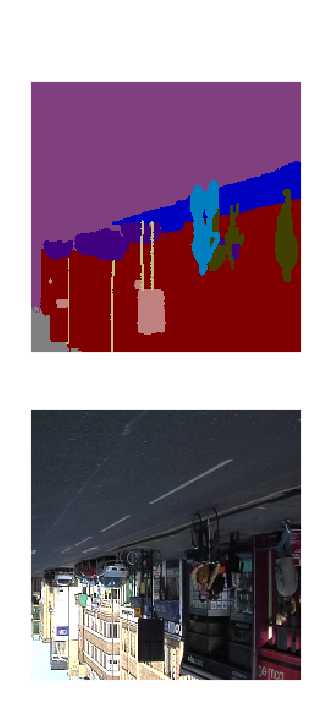

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [8]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
    learning_rate=1e-3,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 224, 224, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
lcn (ContrastNormalization)     (None, 224, 224, 3)  0           pixel_norm[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1344        lcn[0][0]                        
__________________________________________________________________________________________________
batch_norm

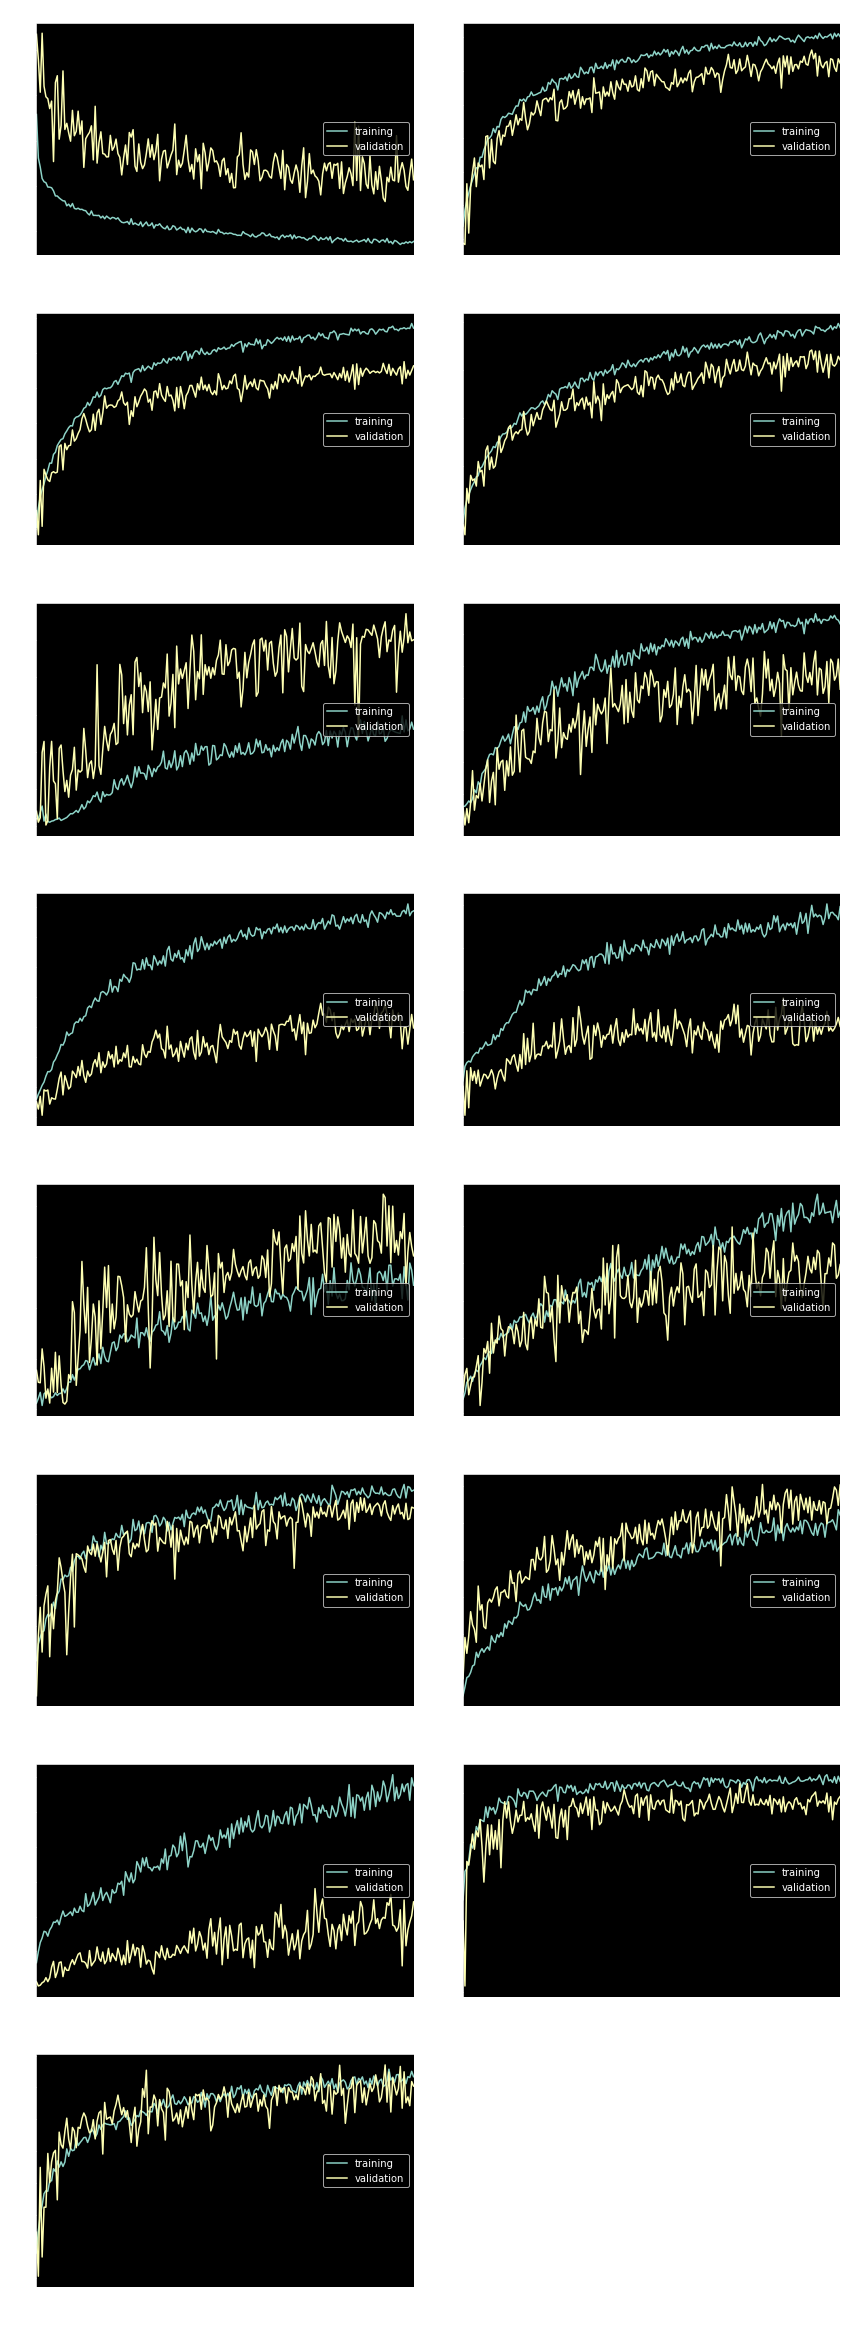

In [9]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / coarse_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotMetrics(),
    ],
    verbose=0
)

In [10]:
history_to_results(history)

train       val
acc                      0.801979  0.723345
Bicyclist                0.260889  0.501567
Building                 0.633115  0.428638
Car                      0.685859  0.296538
Column_Pole              0.248472  0.106771
Fence                    0.244172  0.301929
Pedestrian               0.268999  0.198089
Road                     0.744007  0.685915
Sidewalk                 0.522256  0.603384
SignSymbol               0.286922  0.120894
Sky                      0.845490  0.784810
Tree                     0.633766  0.604189
loss                     0.387611  1.067392
mean_iou                 0.488540  0.421157
mean_per_class_accuracy  0.770533  0.663152

## Test Metrics

In [11]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     0.630893
acc                      0.687612
mean_per_class_accuracy  0.565665
mean_iou                 0.349410
iou_Bicyclist            0.236256
iou_Building             0.402169
iou_Car                  0.339306
iou_Column_Pole          0.196681
iou_Fence                0.060503
iou_Pedestrian           0.139752
iou_Road                 0.598013
iou_Sidewalk             0.532389
iou_SignSymbol           0.114613
iou_Sky                  0.793450
iou_Tree                 0.430378

## Qualitative Results

In [12]:
def predict(generator):
    X, y = next(generator)
    p = model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

In [13]:
X, y, p = predict(generators['train'])

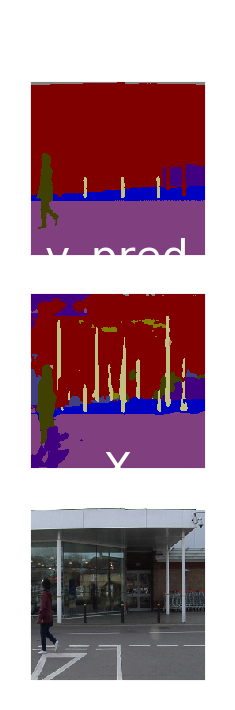

In [14]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

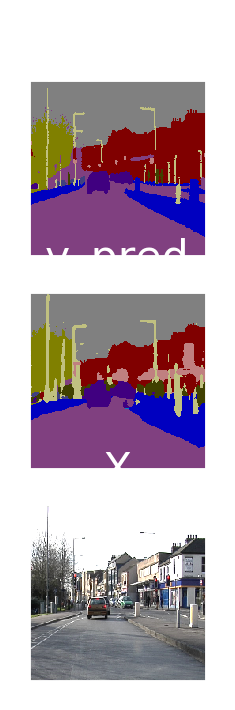

In [15]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

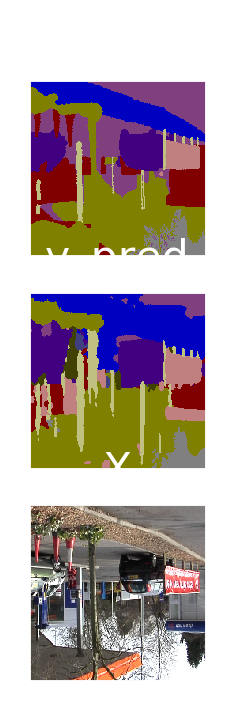

In [16]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

### Validation

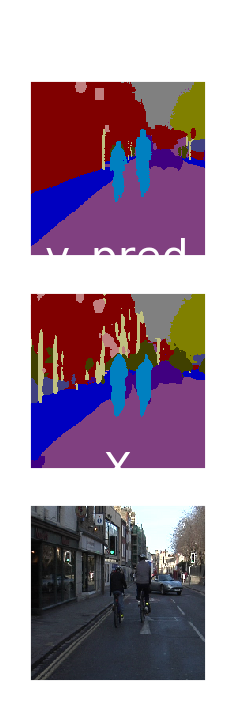

In [17]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

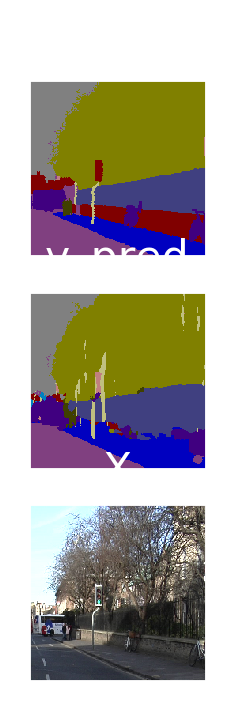

In [18]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

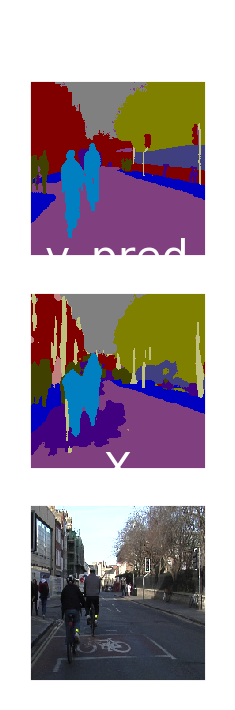

In [19]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

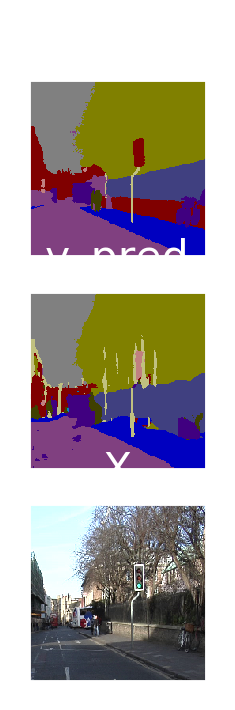

In [20]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

### Test

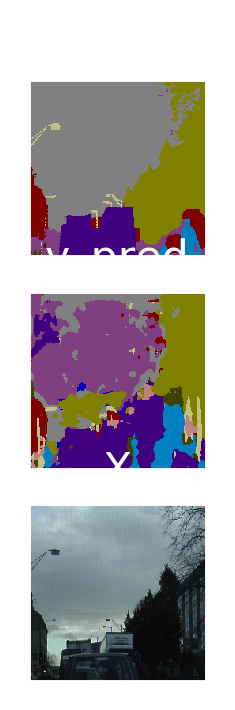

In [21]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

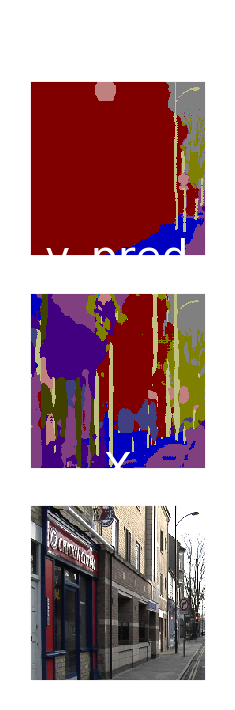

In [22]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

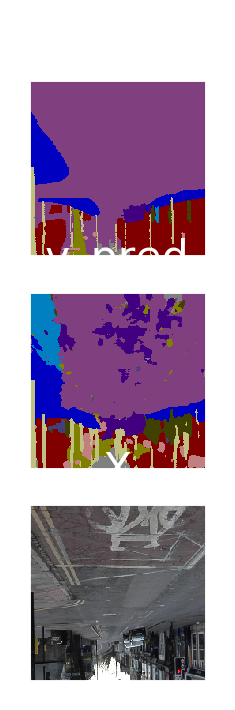

In [23]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

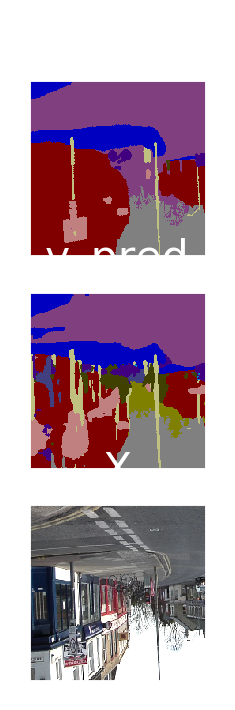

In [24]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [25]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid11-coarse.h5')

# Clear Session

remove the current model from memory.

In [26]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [27]:
camvid11 = camvid.CamVid(
    mapping=mapping, 
    target_size=target_size, 
    crop_size=fine_crop, 
    batch_size=fine_batch
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


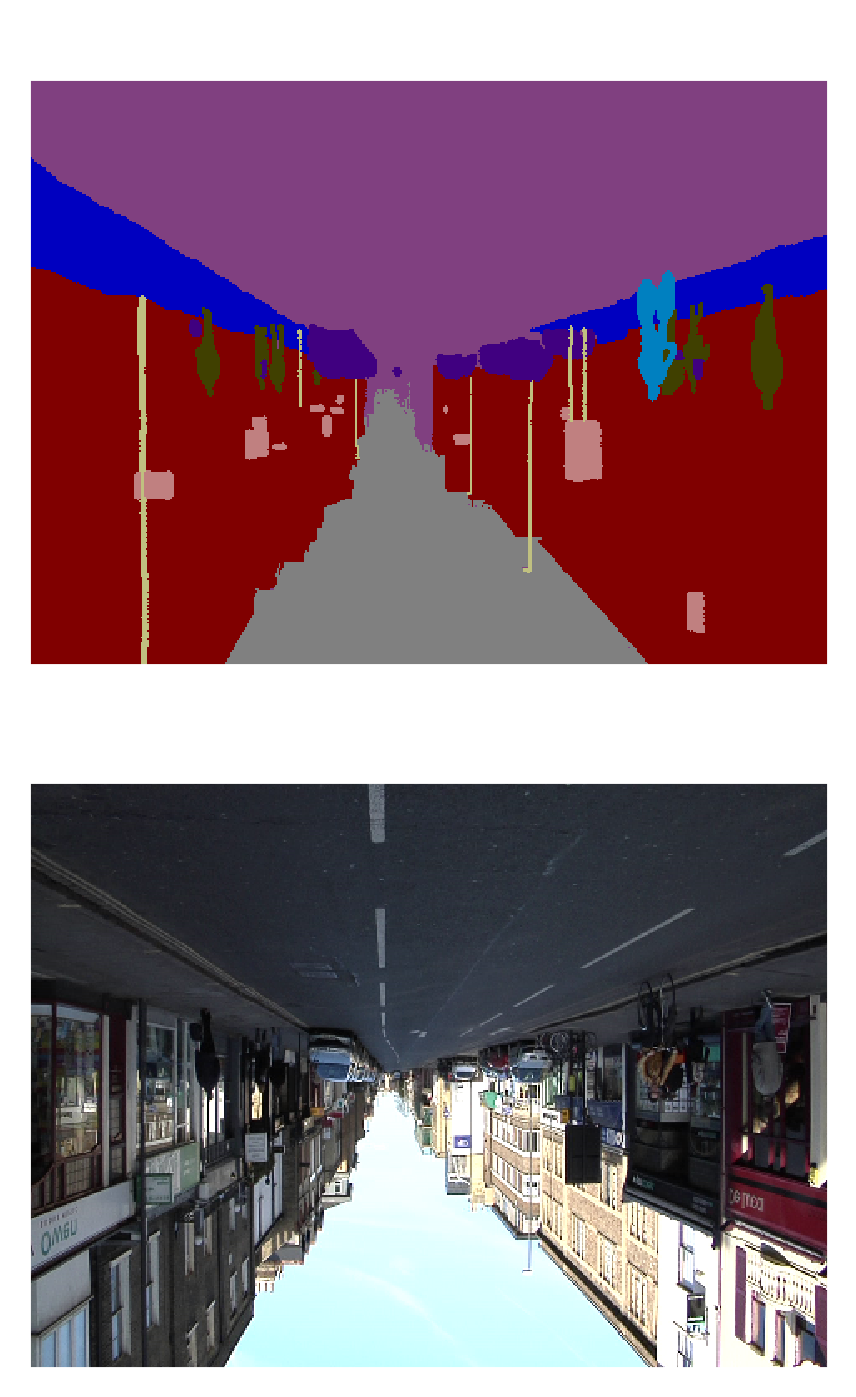

In [28]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [29]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid11-coarse.h5')
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
lcn (ContrastNormalization)     (None, 352, 480, 3)  0           pixel_norm[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        lcn[0][0]                        
__________________________________________________________________________________________________
batch_norm

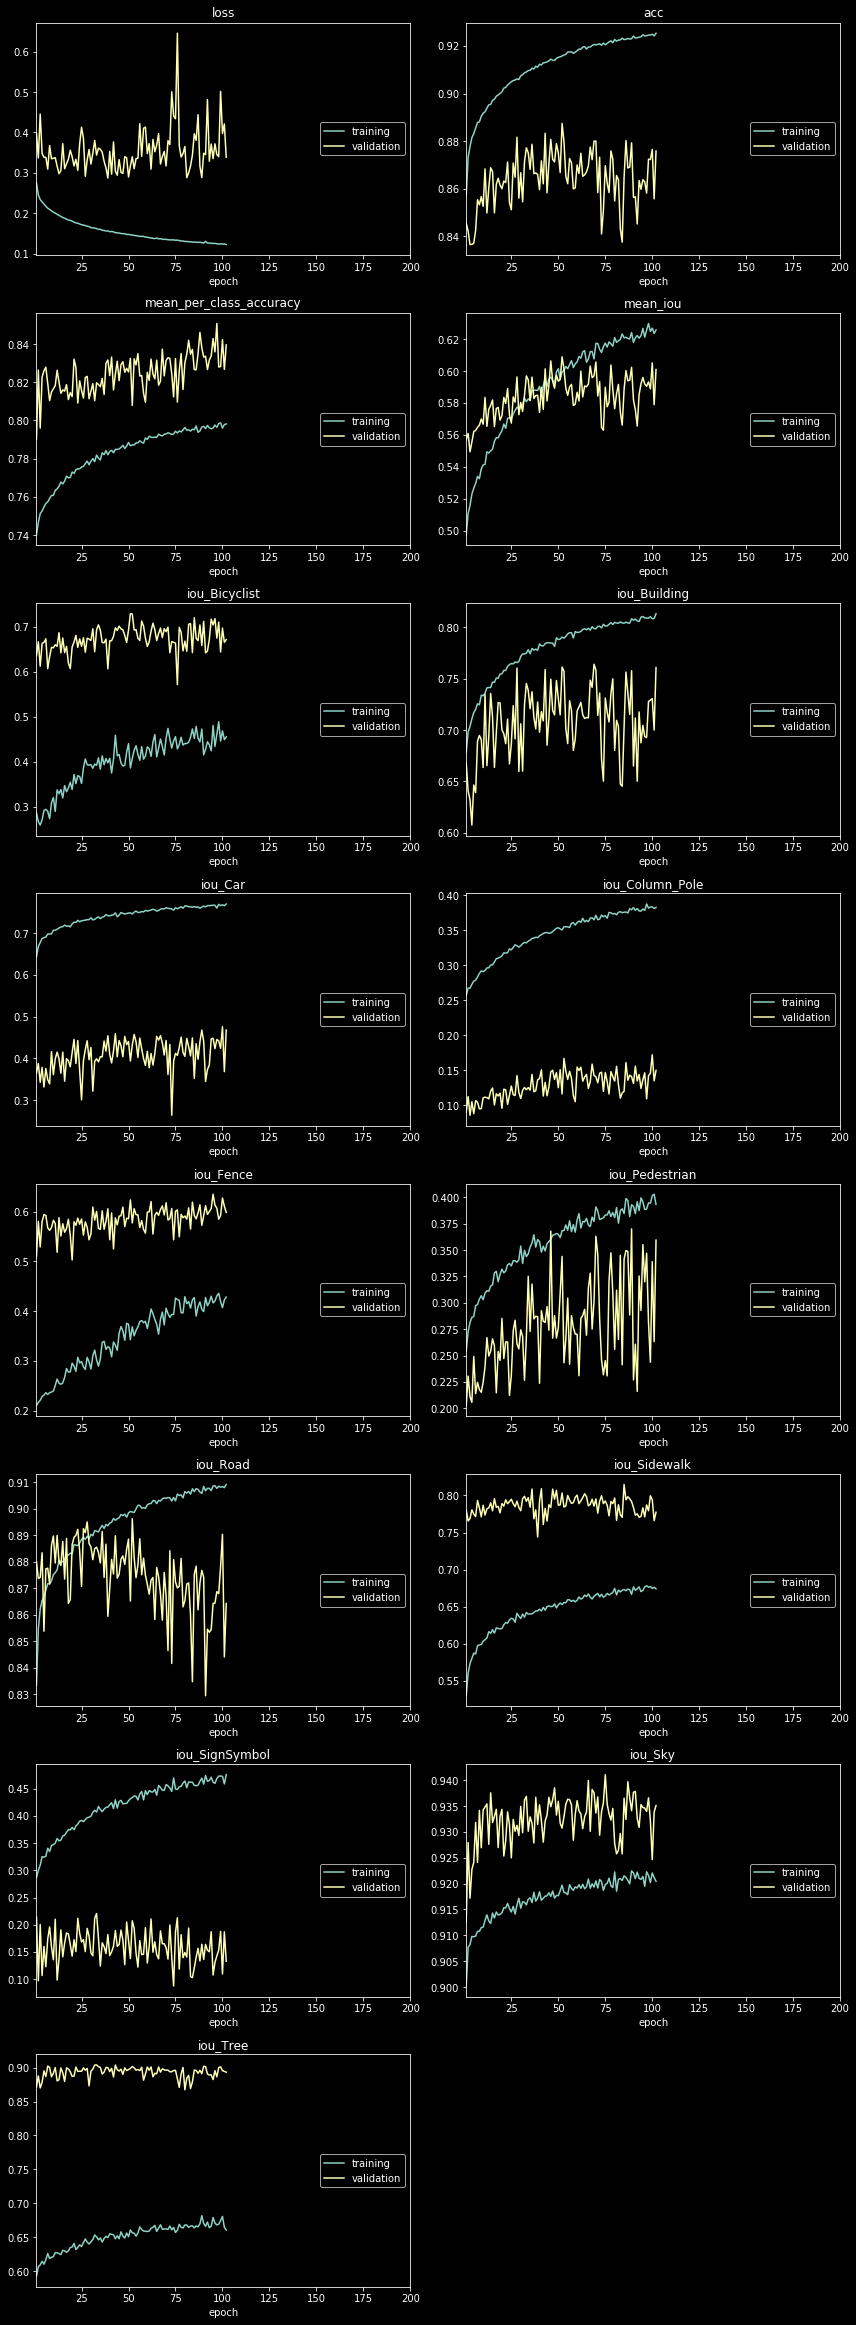

In [33]:
# fit the model with the data.
history = tune_model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / fine_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=50),
        PlotMetrics(),
    ],
    verbose=0,
    max_queue_size=1
)

In [34]:
history_to_results(history)

train       val
acc                      0.925308  0.875834
Bicyclist                0.455372  0.671158
Building                 0.813405  0.760917
Car                      0.770084  0.467837
Column_Pole              0.382099  0.149770
Fence                    0.428202  0.598396
Pedestrian               0.393298  0.359448
Road                     0.909091  0.864147
Sidewalk                 0.674223  0.777409
SignSymbol               0.475693  0.132770
Sky                      0.920452  0.935084
Tree                     0.660678  0.893247
loss                     0.122622  0.338412
mean_iou                 0.625691  0.600926
mean_per_class_accuracy  0.798171  0.839549

## Test Metrics

In [35]:
metrics = tune_model.evaluate_generator(generators['test'], steps=233)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     0.506471
acc                      0.814069
mean_per_class_accuracy  0.648450
mean_iou                 0.443015
iou_Bicyclist            0.080975
iou_Building             0.627993
iou_Car                  0.447337
iou_Column_Pole          0.211398
iou_Fence                0.221945
iou_Pedestrian           0.244067
iou_Road                 0.806656
iou_Sidewalk             0.705870
iou_SignSymbol           0.126961
iou_Sky                  0.878069
iou_Tree                 0.521894

## Qualitative Results

In [36]:
def predict(generator):
    X, y = next(generator)
    p = tune_model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

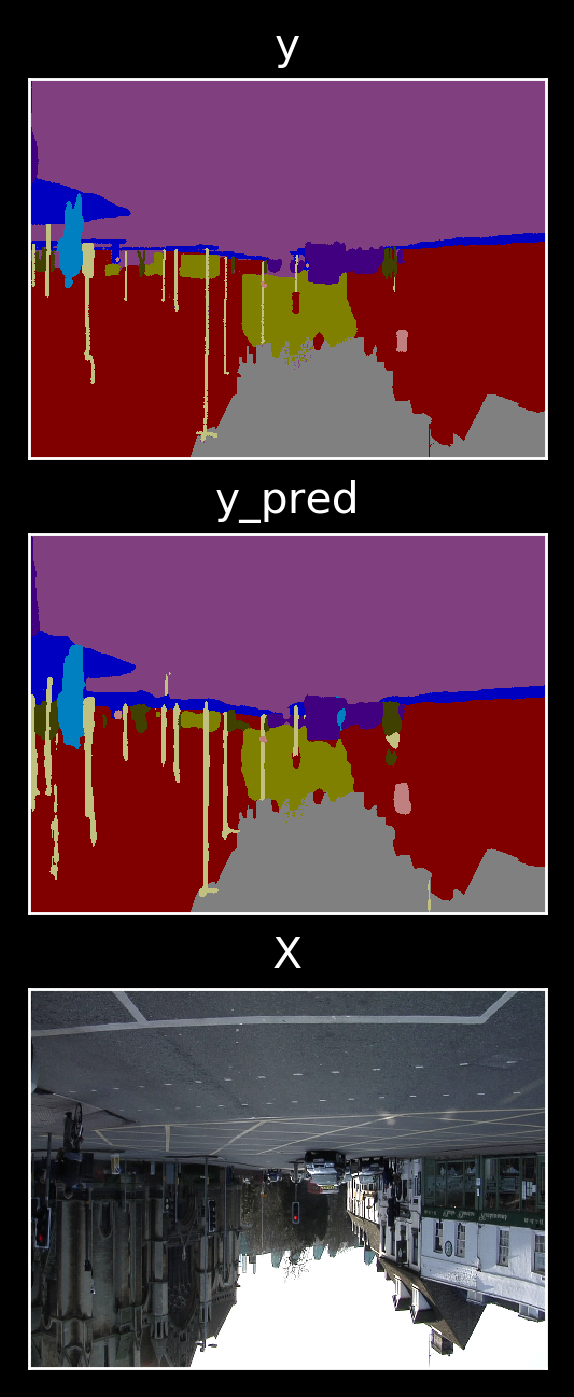

In [37]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

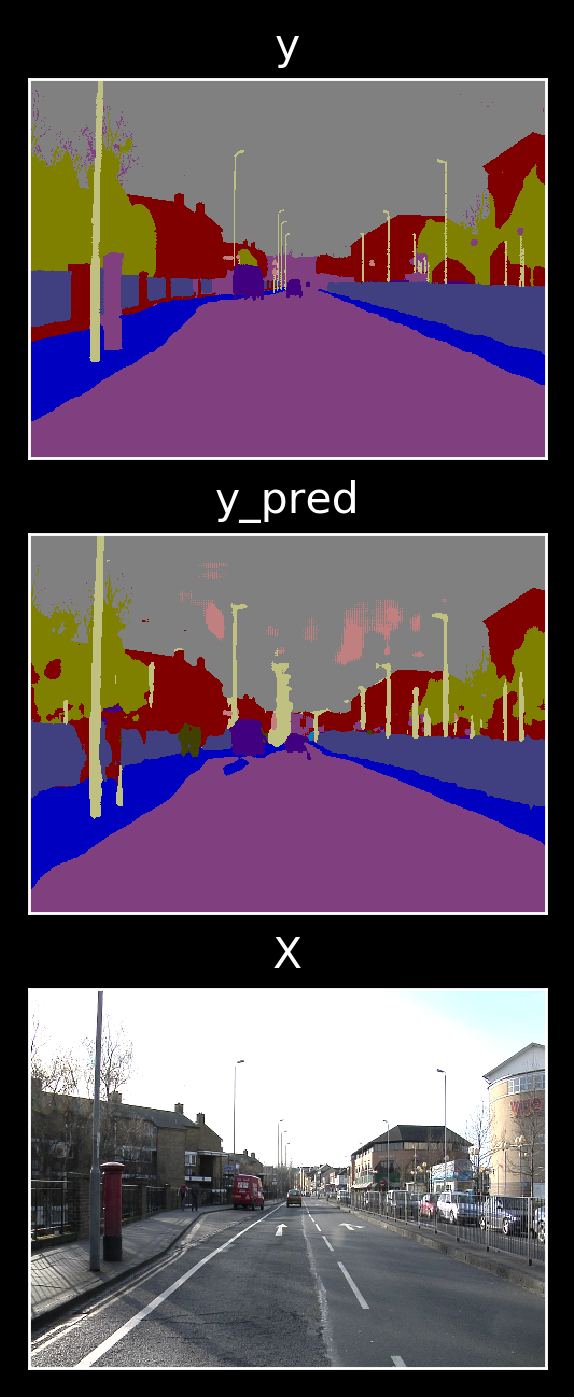

In [38]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

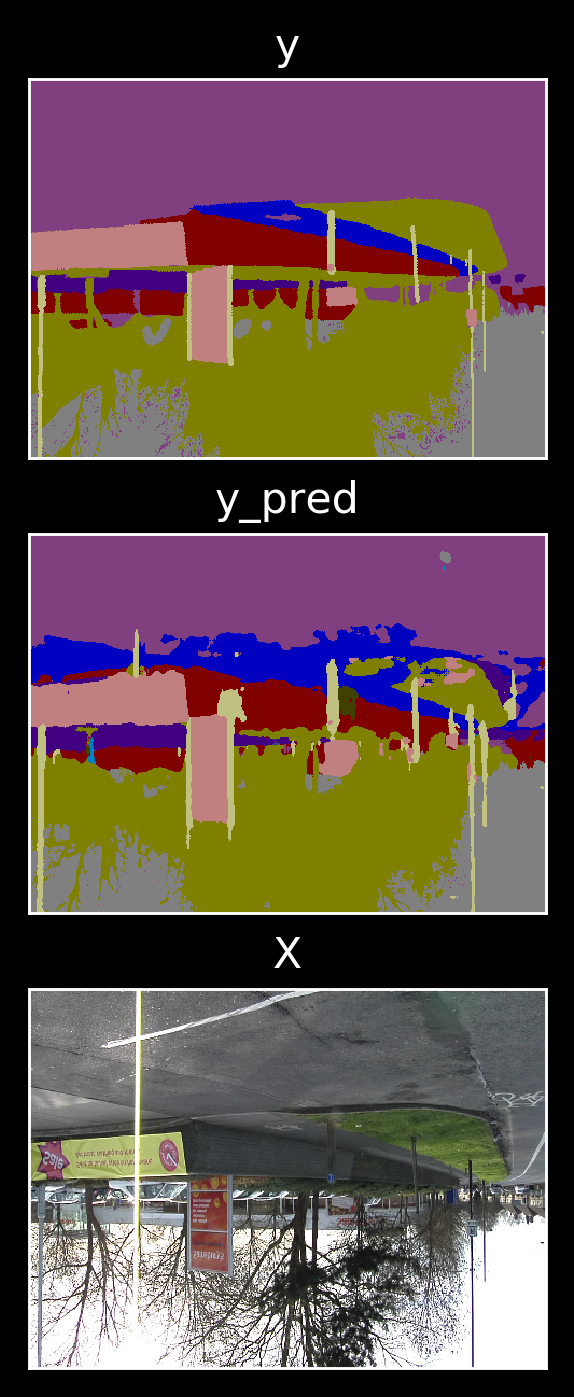

In [39]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

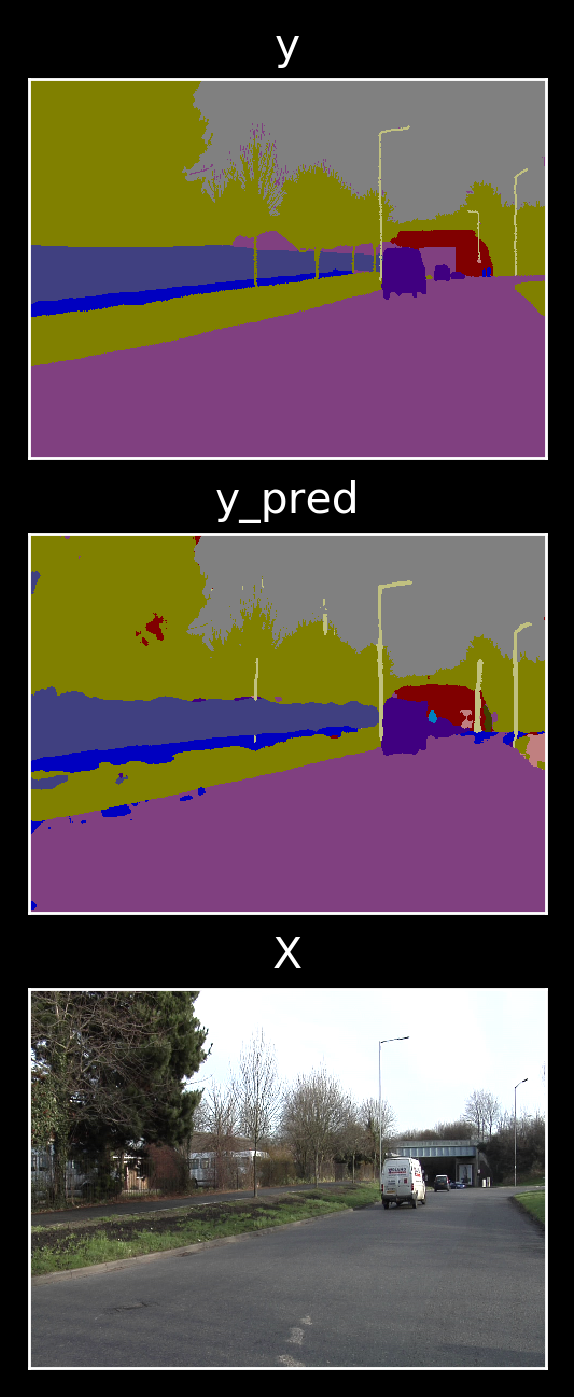

In [40]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

### Validation

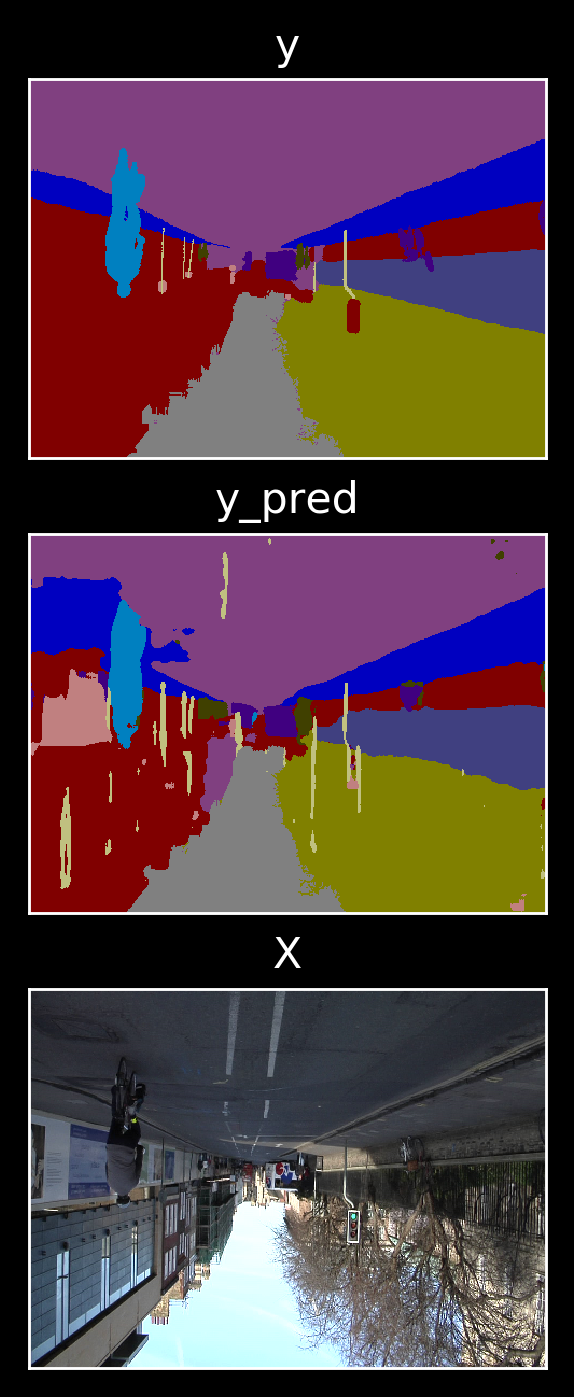

In [41]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

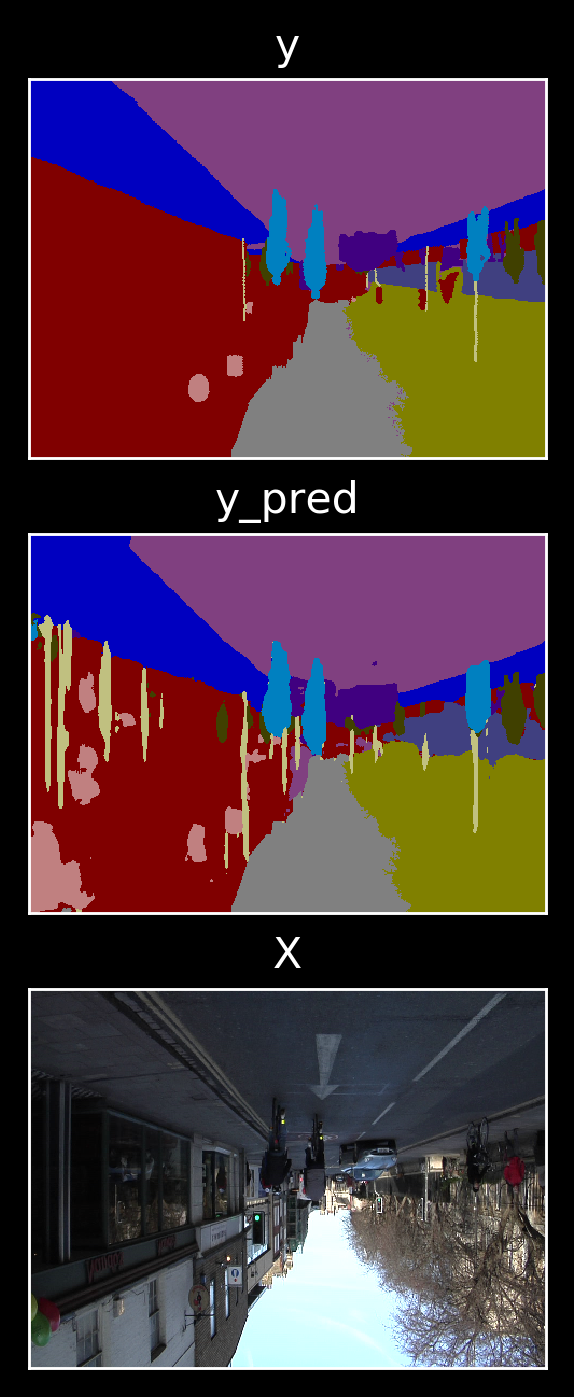

In [42]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

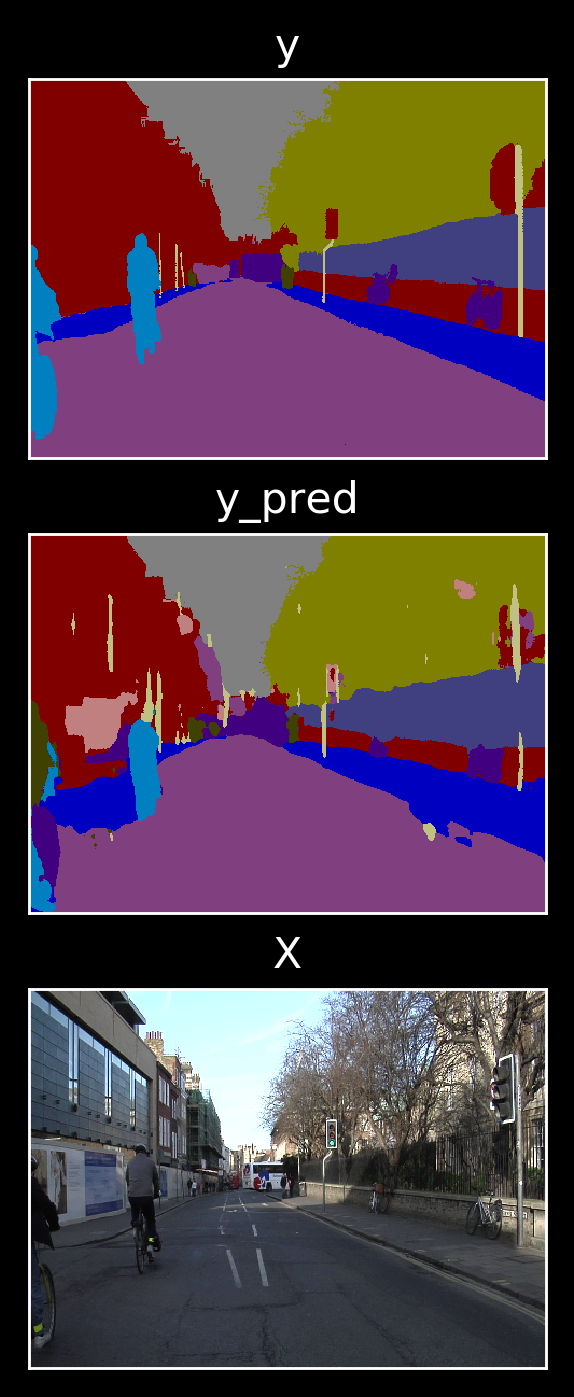

In [43]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

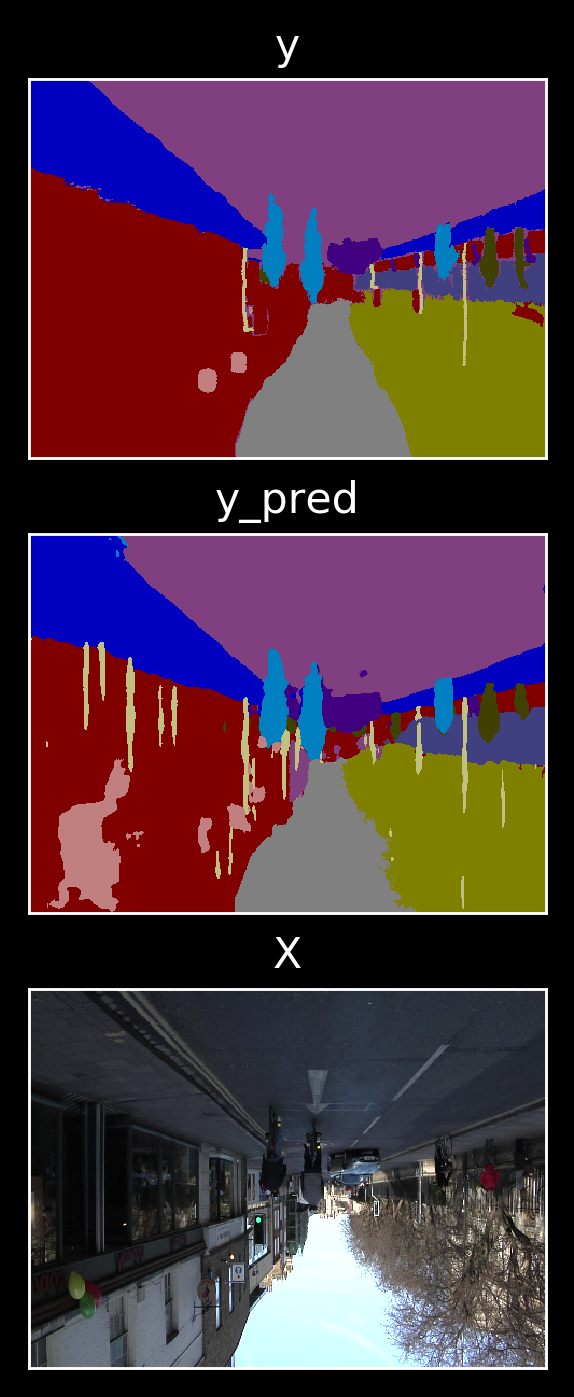

In [44]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

### Test

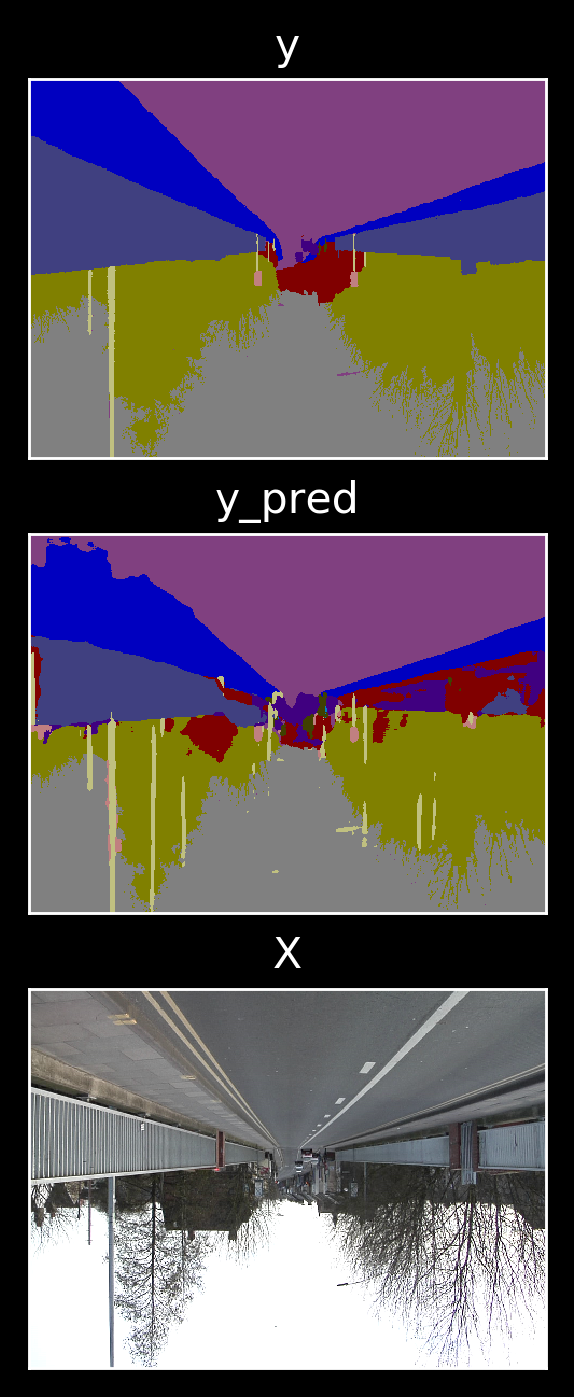

In [45]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

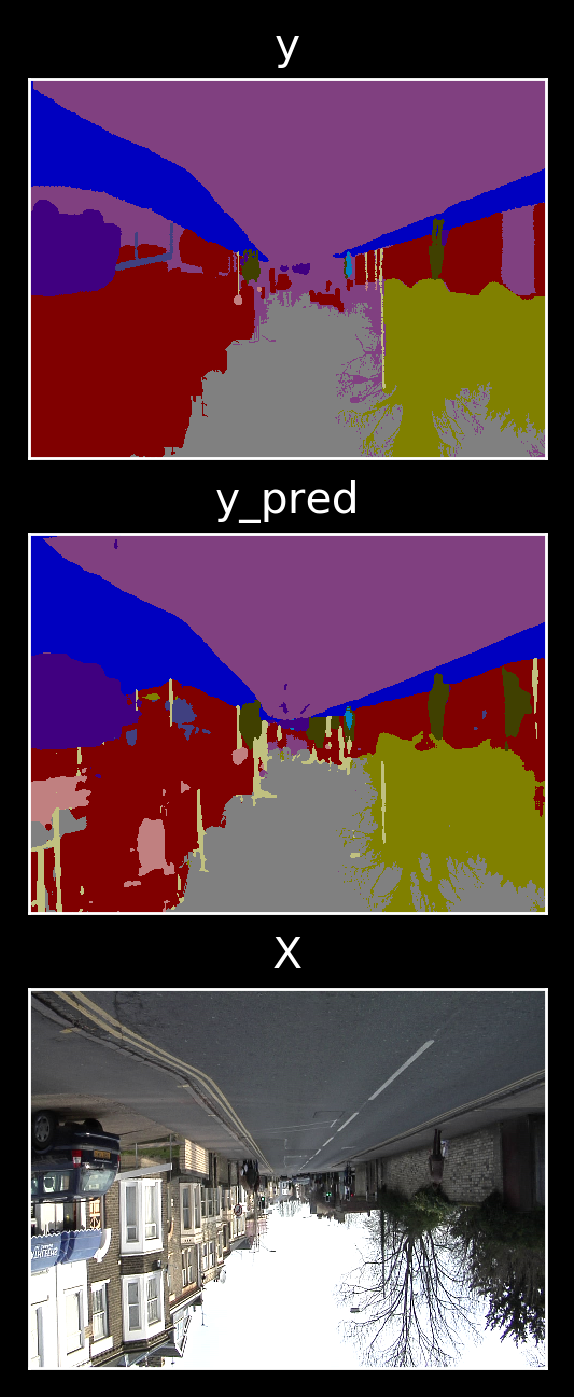

In [46]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

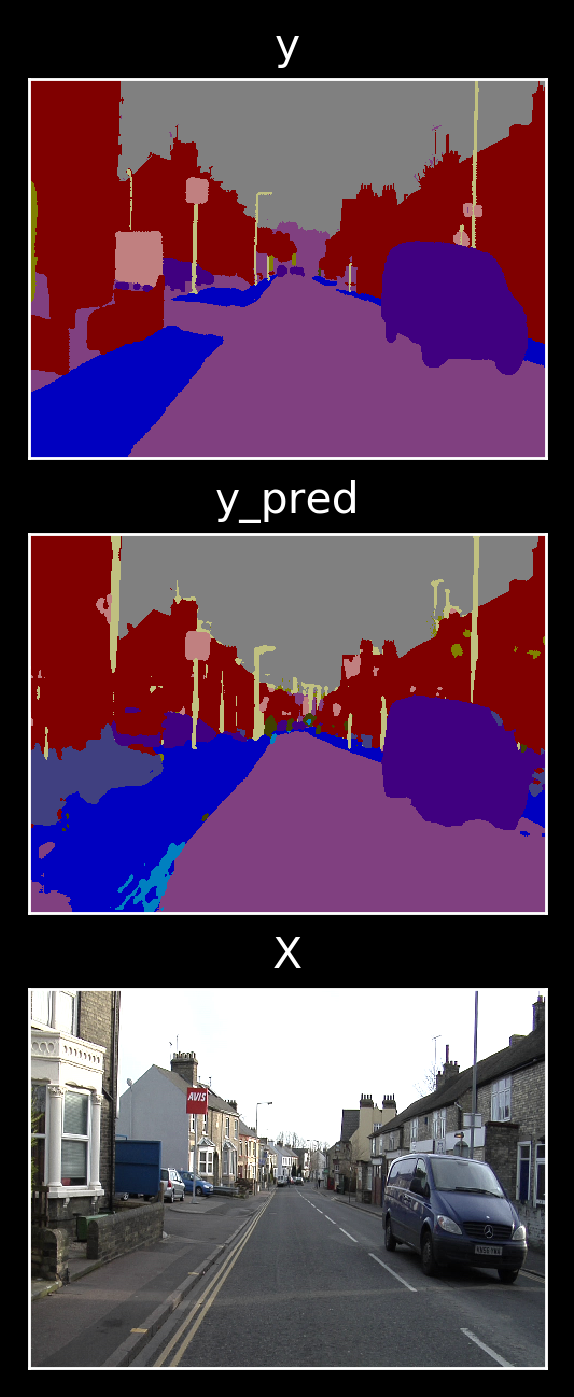

In [47]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

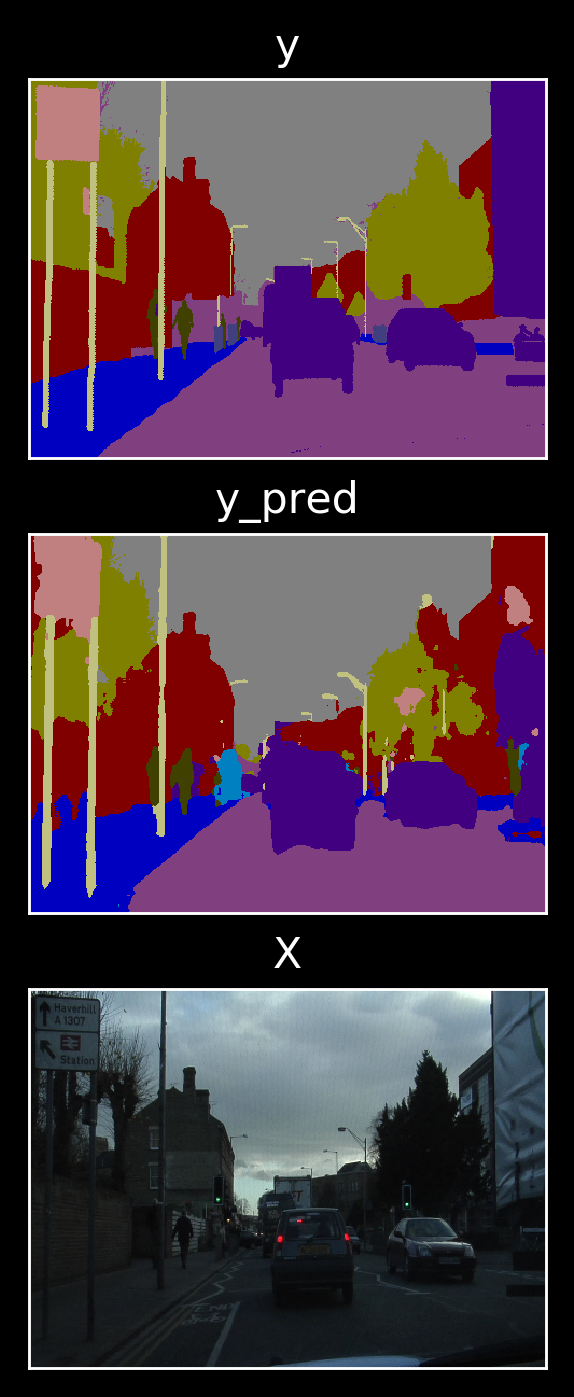

In [48]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [49]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid11-fine.h5')